In [18]:
# SECTION 1: Load Data & Profile
import pandas as pd

# Load CSV
df = pd.read_csv(r"C:\Users\Palan\Desktop\projectA\pythonFiles\invoice_fraud.csv")

# Basic profile
print("Shape:", df.shape)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nData Types:")
print(df.dtypes.to_string())
print("\nClass Distribution:\n", df['IsFraud'].value_counts(normalize=True))


Shape: (20000, 12)

Missing Values:
InvoiceNo            0
PO_No                0
InvoiceSubTotal      0
InvoiceTax           0
InvoiceTotal         0
PO_Amount            0
ExpectedDate         0
PaymentDueDate       0
VendorName           0
Invoice_LineItems    0
PO_LineItems         0
IsFraud              0
dtype: int64

Data Types:
InvoiceNo             object
PO_No                 object
InvoiceSubTotal      float64
InvoiceTax           float64
InvoiceTotal         float64
PO_Amount            float64
ExpectedDate          object
PaymentDueDate        object
VendorName            object
Invoice_LineItems     object
PO_LineItems          object
IsFraud                int64

Class Distribution:
 0    0.6
1    0.4
Name: IsFraud, dtype: float64


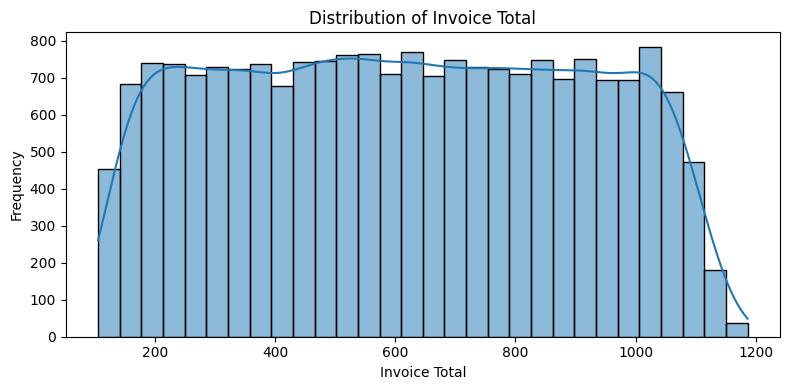

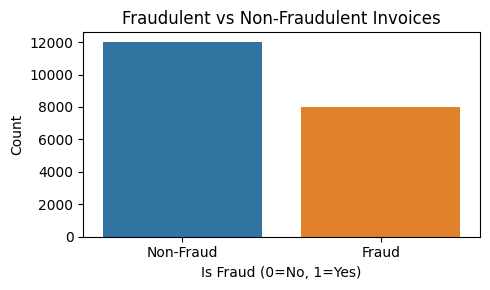

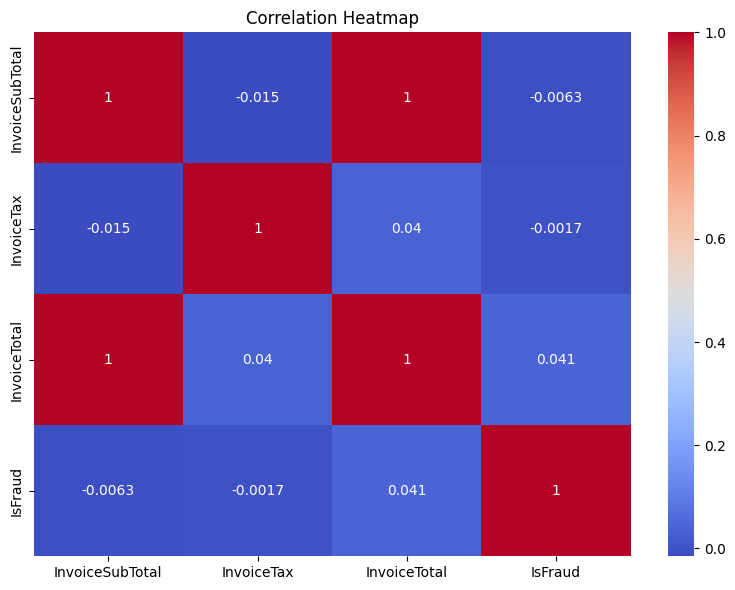

In [19]:
# SECTION 2: Basic EDA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of Invoice Total
plt.figure(figsize=(8, 4))
sns.histplot(df['InvoiceTotal'], bins=30, kde=True)
plt.title("Distribution of Invoice Total")
plt.xlabel("Invoice Total")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 2. Fraud: Bar plot for positive vs negative fraud
plt.figure(figsize=(5, 3))
sns.countplot(x='IsFraud', data=df)
plt.title("Fraudulent vs Non-Fraudulent Invoices")
plt.xlabel("Is Fraud (0=No, 1=Yes)")
plt.ylabel("Count")
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.tight_layout()
plt.show()

# 3. Correlation heatmap (numerical fields)
numeric_cols = ['InvoiceSubTotal', 'InvoiceTax', 'InvoiceTotal']
if all(col in df.columns for col in numeric_cols):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df[numeric_cols + ['IsFraud']].corr(), annot=True, cmap='coolwarm')
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()
else:
    print("Some numeric columns not found. Skipping heatmap.")


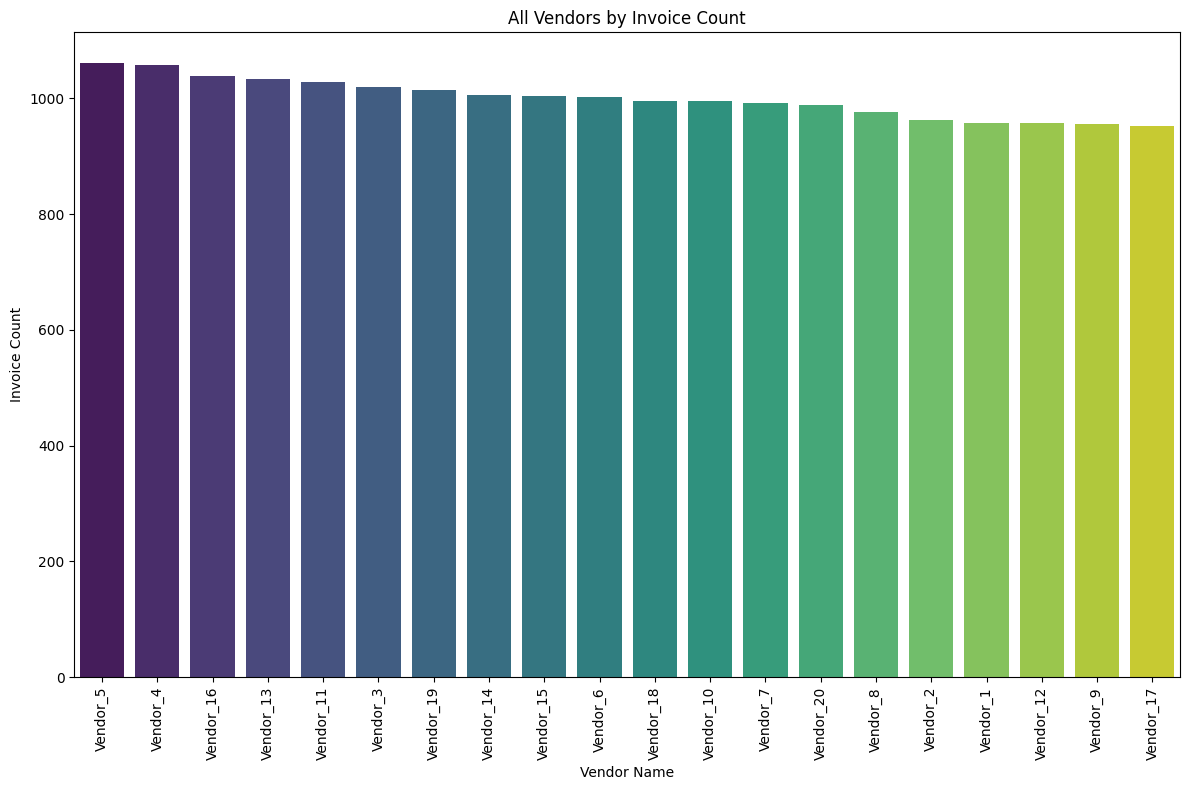

In [20]:
# 4. Vendor Names: Horizontal bar plot for all vendors by invoice count
plt.figure(figsize=(12, 8))
vendor_counts = df['VendorName'].value_counts()
sns.barplot(y=vendor_counts.values, x=vendor_counts.index, palette="viridis")
plt.title("All Vendors by Invoice Count")
plt.ylabel("Invoice Count")
plt.xlabel("Vendor Name")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime

# Copy original DataFrame
df_encoded = df.copy()

# Step 1: Convert 'ExpectedDate' to datetime and create derived features
df_encoded["ExpectedDate"] = pd.to_datetime(df_encoded["ExpectedDate"], errors='coerce')
today = pd.to_datetime(datetime.today().date())

# Create only the derived features needed
df_encoded['IsDueSoon'] = (df_encoded["ExpectedDate"] - today).dt.days < 2

# Convert booleans to int
df_encoded[['IsDueSoon']] = df_encoded[[
    'IsDueSoon'
]].astype(int)

# Step 2: Drop unwanted columns 
drop_cols = [
    "InvoiceNo", "PO_No", "Invoice_LineItems", "PO_LineItems",
    "ExpectedDate", "PaymentDueDate", "VendorName"
]
df_encoded.drop(columns=[col for col in drop_cols if col in df_encoded.columns], inplace=True)

# Step 3: Split features and target
X = df_encoded.drop(columns=["IsFraud"])
y = df_encoded["IsFraud"]

# Step 5: Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)


In [23]:
from math import inf

def early_stop_callback(no_improve_trials):
    # Returns a callback function that stops the study if there is no improvement for `no_improve_trials`.

    best_score = {"value": -inf, "no_improve_count": 0} # -inf so no matter what, the first trial will be better

    def callback(study, trial):
        nonlocal best_score
        if trial.value > best_score["value"]: # Update best score if current trial is better
            best_score["value"] = trial.value # Update the best score
            best_score["no_improve_count"] = 0 # Reset no improvement count
        else:
            best_score["no_improve_count"] += 1  # Increment no improvement count  

        if best_score["no_improve_count"] >= no_improve_trials:
            print(f"Early stopping: No improvement in {no_improve_trials} trials.")
            study.stop()

    return callback


### XGBoost train and test

In [24]:
# SECTION 4: Hyperparameter tuning for XGBoost (reduced complexity)
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer

def objective_xgb(trial):
    clf = XGBClassifier(
        n_estimators=trial.suggest_int('n_estimators', 300, 600),
        max_depth=trial.suggest_int('max_depth', 3, 6),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.1),
        subsample=trial.suggest_float('subsample', 0.7, 0.9),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.7, 0.9),
        scale_pos_weight=trial.suggest_float('scale_pos_weight', 1.0, 3.0),  # Reduce this
        reg_alpha=trial.suggest_float('reg_alpha', 0.0, 3.0),
        reg_lambda=trial.suggest_float('reg_lambda', 10.0, 100.0),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 8),
        gamma=trial.suggest_float('gamma', 0.0, 2.0),
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1
    )
    return cross_val_score(clf, X_train, y_train, cv=5, scoring= make_scorer(f1_score)).mean()

# Run Optuna study
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, callbacks=[early_stop_callback(30)])

print("Best f1 score (XGBoost):", study_xgb.best_trial.value)
print("Best Params (XGBoost):", study_xgb.best_trial.params)


[I 2025-08-05 17:17:32,453] A new study created in memory with name: no-name-9d62b5c7-fc48-46c9-8836-8ab4539b4643
[I 2025-08-05 17:17:45,410] Trial 0 finished with value: 0.8232567492181925 and parameters: {'n_estimators': 599, 'max_depth': 6, 'learning_rate': 0.023394429107060404, 'subsample': 0.7451276416548028, 'colsample_bytree': 0.8078178229242973, 'scale_pos_weight': 2.1782957425026632, 'reg_alpha': 1.018685029115312, 'reg_lambda': 38.01130516376242, 'min_child_weight': 1, 'gamma': 1.164374811038915}. Best is trial 0 with value: 0.8232567492181925.
[I 2025-08-05 17:17:56,415] Trial 1 finished with value: 0.8958329071820448 and parameters: {'n_estimators': 550, 'max_depth': 6, 'learning_rate': 0.05275523734318993, 'subsample': 0.8732615548852113, 'colsample_bytree': 0.8785030404592924, 'scale_pos_weight': 1.724125143348285, 'reg_alpha': 1.8460099893801285, 'reg_lambda': 60.03263093213477, 'min_child_weight': 2, 'gamma': 1.1480521888896302}. Best is trial 1 with value: 0.8958329071

Early stopping: No improvement in 30 trials.
Best f1 score (XGBoost): 0.9521639177747405
Best Params (XGBoost): {'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.09841776475653742, 'subsample': 0.7041757650974727, 'colsample_bytree': 0.8178817839900921, 'scale_pos_weight': 2.933254579050902, 'reg_alpha': 1.1014325078062757, 'reg_lambda': 15.448939474343556, 'min_child_weight': 5, 'gamma': 1.7398742013804975}


In [25]:
# SECTION 5: Final Model Training and Evaluation
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix



# Train final XGBoost model with best params
best_xgb_params = study_xgb.best_params

XGBmodel = XGBClassifier(**best_xgb_params)
XGBmodel.fit(X_train, y_train)
xgb_pred = XGBmodel.predict(X_test)

# Evaluation
print("Final Test F1 Score:", f1_score(y_test, xgb_pred))
print("Final Test Precision:", precision_score(y_test, xgb_pred, zero_division=0))
print("Final Test Recall:", recall_score(y_test, xgb_pred))
print("---------------------------- classification report ---------------------------- \n", classification_report(y_test, xgb_pred, zero_division=0))
print("---------------------------- confusion matrix ---------------------------- \n", confusion_matrix(y_test, xgb_pred))
print("---------------------------- Model fitting test ----------------------------")
print("Training data set f1 score: ", f1_score(y_train, XGBmodel.predict(X_train)))
print("Testing data set f1 score:  ", f1_score(y_test, xgb_pred))

Final Test F1 Score: 0.9443298969072164
Final Test Precision: 0.9744680851063829
Final Test Recall: 0.916
---------------------------- classification report ---------------------------- 
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      3000
           1       0.97      0.92      0.94      2000

    accuracy                           0.96      5000
   macro avg       0.96      0.95      0.95      5000
weighted avg       0.96      0.96      0.96      5000

---------------------------- confusion matrix ---------------------------- 
 [[2952   48]
 [ 168 1832]]
---------------------------- Model fitting test ----------------------------
Training data set f1 score:  0.9915502384338659
Testing data set f1 score:   0.9443298969072164


### Checking feature importance to see if features should be dropped

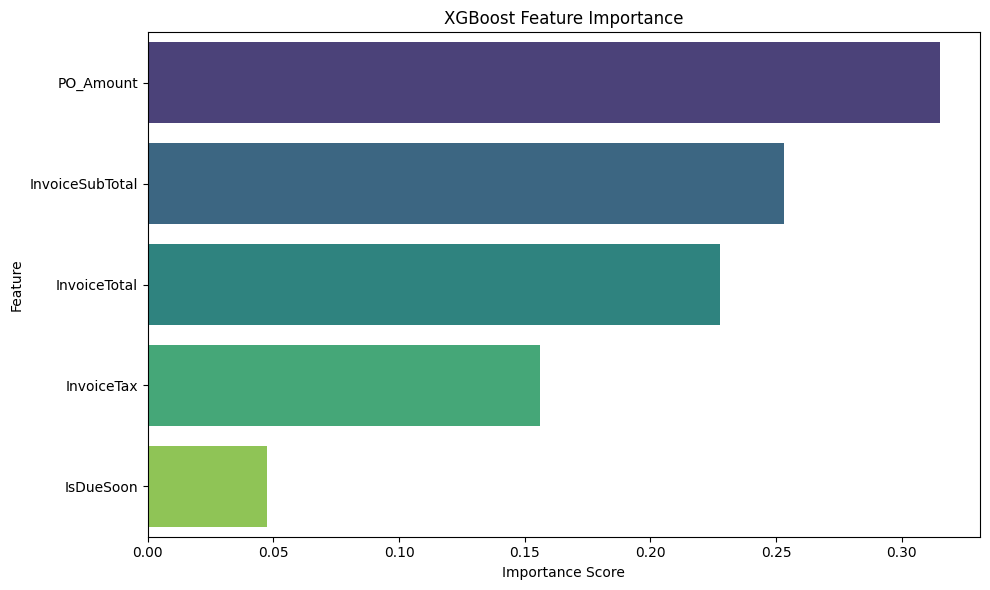

In [26]:
# SECTION 6: Feature Importance Plot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances from trained XGBmodel
importances = XGBmodel.feature_importances_
features = X.columns

# Create importance DataFrame
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [27]:
# Step 1: Keep only top features
important_features = ["PO_Amount", "InvoiceTotal", "InvoiceSubTotal", "InvoiceTax", ]
X_reduced = df_encoded[important_features]
y_reduced = df_encoded["IsFraud"]

# Step 2: Train-test split
from sklearn.model_selection import train_test_split
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    X_reduced, y_reduced, stratify=y_reduced, test_size=0.25, random_state=42
)

# Step 3: Optuna tuning for XGBoost (Reduced Features)
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score)

def objective_xgb_reduced(trial):
    clf = XGBClassifier(
        n_estimators=trial.suggest_int('n_estimators', 100, 400),
        max_depth=trial.suggest_int('max_depth', 3, 5),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.1),
        subsample=trial.suggest_float('subsample', 0.7, 0.9),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.7, 0.9),
        scale_pos_weight=trial.suggest_float('scale_pos_weight', 2, 8),
        reg_alpha=trial.suggest_float('reg_alpha', 0.5, 5.0),
        reg_lambda=trial.suggest_float('reg_lambda', 10.0, 50.0),
        min_child_weight=trial.suggest_int('min_child_weight', 3, 8),
        gamma=trial.suggest_float('gamma', 1.0, 5.0),
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1
    )

    score = cross_val_score(clf, X_train_reduced, y_train_reduced, cv=5, scoring=f1).mean()
    return score

# Run Optuna study
study_xgb_reduced = optuna.create_study(direction='maximize')
study_xgb_reduced.optimize(objective_xgb_reduced, callbacks=[early_stop_callback(30)])

print("Best f1 score (XGBoost Reduced):", study_xgb_reduced.best_trial.value)
print("Best Params (XGBoost Reduced):", study_xgb_reduced.best_trial.params)


[I 2025-08-05 18:10:39,892] A new study created in memory with name: no-name-29fb07be-1d97-4746-b051-3025b9707ac4
[I 2025-08-05 18:10:47,019] Trial 0 finished with value: 0.8470385240798926 and parameters: {'n_estimators': 383, 'max_depth': 5, 'learning_rate': 0.08928533941339277, 'subsample': 0.7810977772211889, 'colsample_bytree': 0.8607564109000653, 'scale_pos_weight': 3.928180103665624, 'reg_alpha': 4.928281259675775, 'reg_lambda': 15.537575264669963, 'min_child_weight': 6, 'gamma': 3.1518398887142225}. Best is trial 0 with value: 0.8470385240798926.
[I 2025-08-05 18:10:50,285] Trial 1 finished with value: 0.6018072310768912 and parameters: {'n_estimators': 256, 'max_depth': 3, 'learning_rate': 0.08142887434617069, 'subsample': 0.8941750676873061, 'colsample_bytree': 0.7274498503578815, 'scale_pos_weight': 3.4054705872279376, 'reg_alpha': 2.7782127441341062, 'reg_lambda': 20.237843801022354, 'min_child_weight': 6, 'gamma': 1.559707424768121}. Best is trial 0 with value: 0.847038524

Early stopping: No improvement in 30 trials.
Best f1 score (XGBoost Reduced): 0.8906441378367479
Best Params (XGBoost Reduced): {'n_estimators': 393, 'max_depth': 4, 'learning_rate': 0.09368526068749708, 'subsample': 0.7822930310131115, 'colsample_bytree': 0.8706603838377348, 'scale_pos_weight': 2.0186336960026, 'reg_alpha': 3.1297316266399897, 'reg_lambda': 39.85462273324574, 'min_child_weight': 8, 'gamma': 1.6760904801977614}


In [28]:
# SECTION 5: Final Model Training and Evaluation
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix



# Train final XGBoost model with best params
best_xgb_params_reduced = study_xgb_reduced.best_params

XGBmodel_reduced = XGBClassifier(**best_xgb_params_reduced)
XGBmodel_reduced.fit(X_train, y_train)
xgb_pred = XGBmodel_reduced.predict(X_test)

# Evaluation
print("Final Test F1 Score:", f1_score(y_test, xgb_pred))
print("Final Test Precision:", precision_score(y_test, xgb_pred, zero_division=0))
print("Final Test Recall:", recall_score(y_test, xgb_pred))
print("---------------------------- classification report ---------------------------- \n", classification_report(y_test, xgb_pred, zero_division=0))
print("---------------------------- confusion matrix ---------------------------- \n", confusion_matrix(y_test, xgb_pred))
print("---------------------------- Model fitting test ----------------------------")
print("Training data set f1 score: ", f1_score(y_train, XGBmodel.predict(X_train)))
print("Testing data set f1 score:  ", f1_score(y_test, xgb_pred))


Final Test F1 Score: 0.8879959819186337
Final Test Precision: 0.8920282542885973
Final Test Recall: 0.884
---------------------------- classification report ---------------------------- 
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      3000
           1       0.89      0.88      0.89      2000

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000

---------------------------- confusion matrix ---------------------------- 
 [[2786  214]
 [ 232 1768]]
---------------------------- Model fitting test ----------------------------
Training data set f1 score:  0.9915502384338659
Testing data set f1 score:   0.8879959819186337


### Comparison
- Model performed better without feature removal so use original model with 91 recall and 97 precision on test (meaning its not overfit)

In [29]:
import joblib

# Save XGBoost model to file
joblib.dump(XGBmodel, "xgb_fraud_model.joblib")


['xgb_fraud_model.joblib']

In [30]:
import xgboost as xgb; print(xgb.__version__)


1.6.2
